In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from epam.dnsm import TransformerBinarySelectionModel, DNSMBurrito
from epam.sequences import translate_sequences
from epam.shmple_precompute import load_and_convert_to_tensors

In [2]:
pcp_df = load_and_convert_to_tensors("/Users/matsen/data/wyatt-10x-1p5m_pcp_2023-10-07.mimic-only_allow_mutations_next_to_hydrophobic_sites.shmple.hdf5")
# pcp_df = load_and_convert_to_tensors("/Users/matsen/data/wyatt-10x-1p5m_pcp_2023-10-07.first100.shmple.hdf5")

# filter out rows of pcp_df where the parent and child sequences are identical
pcp_df = pcp_df[pcp_df["parent"] != pcp_df["child"]]

# NOTE downsampling here
downsample_count = 5000
if len(pcp_df) > downsample_count:
    pcp_df = pcp_df.sample(downsample_count, random_state=42)

print(f"We have {len(pcp_df)} PCPs.")

We have 5000 PCPs.


In [3]:
nhead = 2
dim_feedforward = 2048
layer_count = 2

dnsm = TransformerBinarySelectionModel(
    nhead=nhead, dim_feedforward=dim_feedforward, layer_count=layer_count
)

burrito = DNSMBurrito(pcp_df, dnsm, batch_size=1024, learning_rate=0.001, checkpoint_dir="./_checkpoints", log_dir="./_logs")

Using Metal Performance Shaders
preparing data...
consolidating shmple rates into substitution probabilities...
consolidating shmple rates into substitution probabilities...


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def selection_factor_neighbor_plot(model):
    parents = pcp_df.reset_index(drop=True)["parent"]
    if len(parents) > 1000:
        parents = parents.sample(1000)
    aa_parents = translate_sequences(parents)
    selection_factor_arrays = [model.selection_factors_of_aa_str(aa_str).cpu().numpy() for aa_str in aa_parents]

    hydrophobic_aas = set(list("AILMFWV"))

    def selection_factor_means(aa_str, selection_factor_array):
        adjacent_hydrophobic_selection_factors = []
        other_selection_factors = []
        
        # Check for each position in the amino acid string
        for i, aa in enumerate(aa_str):
            if aa not in hydrophobic_aas:
                if (i > 0 and aa_str[i-1] in hydrophobic_aas) or \
                   (i < len(aa_str) - 1 and aa_str[i+1] in hydrophobic_aas):
                    # The current amino acid is adjacent to a hydrophobic one
                    adjacent_hydrophobic_selection_factors.append(selection_factor_array[i])
                else:
                    other_selection_factors.append(selection_factor_array[i])
        
        return {
            "adjacent_hydrophobic_selection_mean": np.mean(adjacent_hydrophobic_selection_factors) if adjacent_hydrophobic_selection_factors else np.nan,
            "other_selection_mean": np.mean(other_selection_factors) if other_selection_factors else np.nan
        }

    df = pd.DataFrame([selection_factor_means(aa_str, selection_factor_array) for aa_str, selection_factor_array in zip(aa_parents, selection_factor_arrays)])

    # Scatter plot
    plt.scatter(df['adjacent_hydrophobic_selection_mean'], df['other_selection_mean'], label='sequences', alpha=0.1)
    plt.xlabel('Adjacent Hydrophobic Selection Mean')
    plt.ylabel('Other Selection Mean')

    # Add x=y line
    lims = [
        np.nanmin([plt.xlim(), plt.ylim()]),  
        np.nanmax([plt.xlim(), plt.ylim()]),  
    ]
    plt.plot(lims, lims, 'k--', alpha=0.5, label='x=y line')
    plt.xlim(lims)
    plt.ylim(lims)

    plt.legend()
    plt.show()


In [5]:
burrito.train(15)
burrito.optimize_branch_lengths()
burrito.train(50)
burrito.optimize_branch_lengths()
burrito.train(50)

Epoch [0/15], Training Loss: 0.162361491471529, Validation Loss: 0.15994369983673096
training model...
Epoch [1/15], Training Loss: 0.15340164303779602, Validation Loss: 0.15667018294334412
Epoch [2/15], Training Loss: 0.15535852313041687, Validation Loss: 0.15540790557861328
Epoch [3/15], Training Loss: 0.1540507972240448, Validation Loss: 0.15537117421627045
Epoch [4/15], Training Loss: 0.1580641269683838, Validation Loss: 0.1552356332540512
Epoch [5/15], Training Loss: 0.15722595155239105, Validation Loss: 0.15506446361541748
Epoch [6/15], Training Loss: 0.1607786864042282, Validation Loss: 0.15545767545700073
Epoch [7/15], Training Loss: 0.15458528697490692, Validation Loss: 0.1551225632429123
Epoch [8/15], Training Loss: 0.152703657746315, Validation Loss: 0.15487612783908844
Epoch [9/15], Training Loss: 0.1569826602935791, Validation Loss: 0.15537333488464355
Epoch [10/15], Training Loss: 0.16263212263584137, Validation Loss: 0.15583482384681702
Epoch [11/15], Training Loss: 0.16

Finding optimal branch lengths: 100%|██████████| 4000/4000 [01:40<00:00, 39.79it/s]


consolidating shmple rates into substitution probabilities...


Finding optimal branch lengths: 100%|██████████| 1000/1000 [00:23<00:00, 42.14it/s]


consolidating shmple rates into substitution probabilities...
Epoch [0/50], Training Loss: 0.15340298414230347, Validation Loss: 0.1519736647605896
training model...
Epoch [1/50], Training Loss: 0.1516553908586502, Validation Loss: 0.15218518674373627
Epoch [2/50], Training Loss: 0.15602774918079376, Validation Loss: 0.15190334618091583
Epoch [3/50], Training Loss: 0.14849109947681427, Validation Loss: 0.15082800388336182
Epoch [4/50], Training Loss: 0.1529015749692917, Validation Loss: 0.15058225393295288
Epoch [5/50], Training Loss: 0.14837324619293213, Validation Loss: 0.15078778564929962
Epoch [6/50], Training Loss: 0.1528608202934265, Validation Loss: 0.1502838283777237
Epoch [7/50], Training Loss: 0.16040468215942383, Validation Loss: 0.15085509419441223
Epoch [8/50], Training Loss: 0.15119363367557526, Validation Loss: 0.1506374329328537
Epoch [9/50], Training Loss: 0.15338607132434845, Validation Loss: 0.15036971867084503
Epoch [10/50], Training Loss: 0.14880214631557465, Valid

Finding optimal branch lengths: 100%|██████████| 4000/4000 [01:03<00:00, 62.80it/s]


consolidating shmple rates into substitution probabilities...


Finding optimal branch lengths: 100%|██████████| 1000/1000 [00:15<00:00, 63.46it/s]


consolidating shmple rates into substitution probabilities...
Epoch [0/50], Training Loss: 0.15096953138709068, Validation Loss: 0.147740438580513
training model...
Epoch [1/50], Training Loss: 0.15041349828243256, Validation Loss: 0.14659473299980164
Epoch [2/50], Training Loss: 0.1557690054178238, Validation Loss: 0.1469614952802658
Epoch [3/50], Training Loss: 0.14718298614025116, Validation Loss: 0.14661374688148499
Epoch [4/50], Training Loss: 0.1541026383638382, Validation Loss: 0.14674100279808044
Epoch [5/50], Training Loss: 0.1506536900997162, Validation Loss: 0.14664249122142792
Epoch [6/50], Training Loss: 0.1487390100955963, Validation Loss: 0.14647679030895233
Epoch [7/50], Training Loss: 0.14765070378780365, Validation Loss: 0.14649337530136108
Epoch [8/50], Training Loss: 0.15360772609710693, Validation Loss: 0.14619717001914978
Epoch [9/50], Training Loss: 0.15615195035934448, Validation Loss: 0.1464848667383194
Epoch [10/50], Training Loss: 0.14975054562091827, Validat

In [6]:
burrito.train_set.branch_lengths

array([0.07933443, 0.03378119, 0.08209625, ..., 0.04213512, 0.03736816,
       0.03176052])

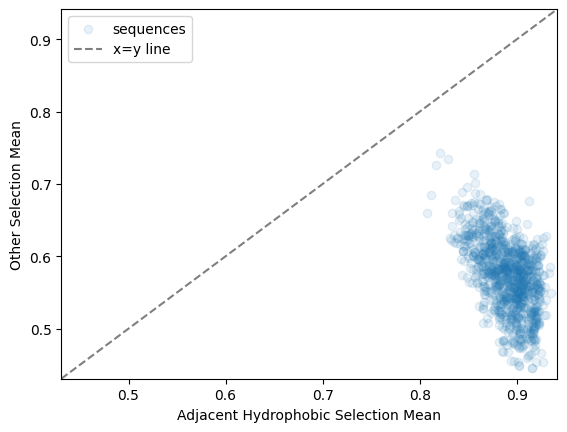

In [7]:
selection_factor_neighbor_plot(burrito.dnsm)

In [8]:
[aa_str] = translate_sequences([pcp_df.reset_index(drop=True).loc[0, "parent"]])
burrito.dnsm.selection_factors_of_aa_str(aa_str)

tensor([1.0000, 0.6491, 1.0000, 1.0000, 1.0000, 1.0000, 0.4607, 0.3360, 0.8063,
        0.4114, 1.0000, 1.0000, 1.0000, 0.1644, 0.4422, 0.5843, 1.0000, 0.9346,
        1.0000, 0.9496, 1.0000, 0.8343, 1.0000, 1.0000, 1.0000, 0.6650, 0.7307,
        1.0000, 0.5160, 1.0000, 0.2930, 0.6200, 0.8276, 0.7827, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.6406, 0.8142, 0.2011, 0.4752, 0.3937, 0.3036,
        0.9178, 1.0000, 0.8142, 0.2613, 1.0000, 0.5519, 0.7833, 0.1920, 0.2049,
        0.1930, 0.1888, 0.1799, 0.3436, 0.2572, 0.5525, 0.5360, 0.7974, 0.4894,
        0.7437, 1.0000, 0.5985, 0.9938, 0.6539, 0.7398, 0.5766, 0.9084, 0.7790,
        0.8973, 0.5243, 0.4568, 0.4664, 0.6805, 0.8667, 0.7765, 1.0000, 0.2063,
        1.0000, 0.4874, 1.0000, 1.0000, 0.3467, 1.0000, 0.8813, 0.8947, 0.7710,
        1.0000, 1.0000, 0.9083, 0.8879, 0.7518, 0.7910, 0.8061, 1.0000, 0.8991,
        1.0000, 0.8461, 0.8547, 0.7121, 0.7809, 0.9287, 0.6894, 0.9686, 1.0000,
        0.6646, 0.9723, 1.0000, 0.9490, 

In [9]:
# nhead = 4
# dim_feedforward = 2048
# layer_count = 3
# 
# model = TransformerBinarySelectionModel(
#     nhead=nhead, dim_feedforward=dim_feedforward, layer_count=layer_count
# )
# 
# model.load_state_dict(torch.load("../_trained_dnsms/dnsm-hydrophobic-2023-11-01.pth")["model_state_dict"])
# model.eval()



In [10]:
# model = TransformerBinarySelectionModel(
#     nhead=nhead, dim_feedforward=dim_feedforward, layer_count=layer_count
# )
nobl_trained_dnsm = TransformerBinarySelectionModel(
    nhead=nhead, dim_feedforward=dim_feedforward, layer_count=layer_count
)

nobl_trained_burrito = DNSMBurrito(pcp_df, nobl_trained_dnsm, batch_size=1024, learning_rate=0.001, checkpoint_dir="./_checkpoints", log_dir="./_logs")

nobl_trained_burrito.train(50)

model = nobl_trained_burrito.dnsm


Using Metal Performance Shaders
preparing data...
consolidating shmple rates into substitution probabilities...
consolidating shmple rates into substitution probabilities...
Epoch [0/50], Training Loss: 0.1593753807246685, Validation Loss: 0.15925420820713043
training model...
Epoch [1/50], Training Loss: 0.1568930298089981, Validation Loss: 0.15640100836753845
Epoch [2/50], Training Loss: 0.16337749361991882, Validation Loss: 0.1555478572845459
Epoch [3/50], Training Loss: 0.16391880810260773, Validation Loss: 0.1557122766971588
Epoch [4/50], Training Loss: 0.15443158149719238, Validation Loss: 0.15547917783260345
Epoch [5/50], Training Loss: 0.15645362436771393, Validation Loss: 0.15529100596904755
Epoch [6/50], Training Loss: 0.15228712558746338, Validation Loss: 0.15527135133743286
Epoch [7/50], Training Loss: 0.1577899158000946, Validation Loss: 0.15503688156604767
Epoch [8/50], Training Loss: 0.15563274919986725, Validation Loss: 0.15557532012462616
Epoch [9/50], Training Loss: 0

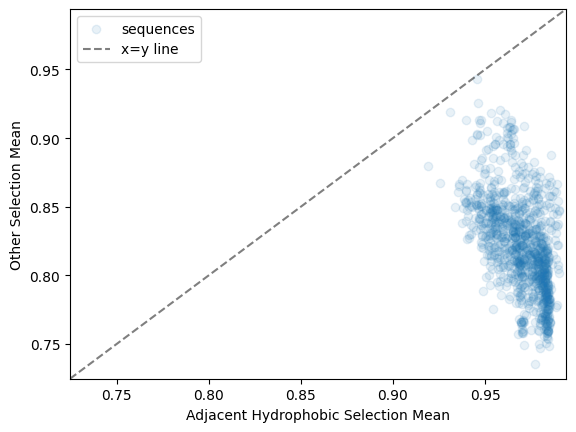

In [11]:
selection_factor_neighbor_plot(nobl_trained_burrito.dnsm)